### Imports

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from keras import layers, Input, Model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

%matplotlib inline

### Loading data

In [27]:
data_dir = '../input/'
!ls {data_dir}

sample_submission.csv  test.csv  train.csv


In [28]:
train_raw = pd.read_csv(f'{data_dir}train.csv')
train_raw.head()

,id,muggy-smalt-axolotl-pembus,dorky-peach-sheepdog-ordinal,slimy-seashell-cassowary-goose,snazzy-harlequin-chicken-distraction,frumpy-smalt-mau-ordinal,stealthy-beige-pinscher-golden,chummy-cream-tarantula-entropy,hazy-emerald-cuttlefish-unsorted,nerdy-indigo-wolfhound-sorted,leaky-amaranth-lizard-sorted,ugly-tangerine-chihuahua-important,shaggy-silver-indri-fimbus,flaky-chocolate-beetle-grandmaster,squirrely-harlequin-sheep-sumble,freaky-tan-angelfish-noise,lousy-plum-penguin-sumble,bluesy-rose-wallaby-discard,baggy-copper-oriole-dummy,stealthy-scarlet-hound-fepid,greasy-cinnamon-bonobo-contributor,cranky-cardinal-dogfish-ordinal,snippy-auburn-vole-learn,greasy-sepia-coral-dataset,flabby-tangerine-fowl-entropy,lousy-smalt-pinscher-dummy,bluesy-brass-chihuahua-distraction,goopy-eggplant-indri-entropy,homey-sepia-bombay-sorted,homely-ruby-bulldog-entropy,hasty-blue-sheep-contributor,blurry-wisteria-oyster-master,snoopy-auburn-dogfish-expert,stinky-maroon-blue-kernel,bumpy-amaranth-armadillo-important,slaphappy-peach-oyster-master,dorky-tomato-ragdoll-dataset,messy-mauve-wolverine-ordinal,geeky-pumpkin-moorhen-important,crabby-teal-otter-unsorted,...,beady-mauve-frog-distraction,surly-brass-maltese-ordinal,beady-asparagus-opossum-expert,beady-rust-impala-dummy,droopy-amethyst-dachshund-hint,homey-crimson-budgerigar-grandmaster,droopy-cardinal-impala-important,woozy-apricot-moose-hint,paltry-sapphire-labradoodle-dummy,crappy-carmine-eagle-entropy,greasy-magnolia-spider-grandmaster,crabby-carmine-flounder-sorted,skimpy-copper-fowl-grandmaster,hasty-seashell-woodpecker-hint,snappy-purple-bobcat-important,thirsty-carmine-corgi-ordinal,homely-auburn-reindeer-unsorted,crappy-beige-tiger-fepid,cranky-auburn-swan-novice,chewy-bistre-buzzard-expert,skinny-cyan-macaque-pembus,slimy-periwinkle-otter-expert,snazzy-burgundy-clam-novice,cozy-ochre-gorilla-gaussian,homey-sangria-wolfhound-dummy,snazzy-asparagus-hippopotamus-contributor,paltry-red-hamster-sorted,zippy-dandelion-insect-golden,baggy-coral-bandicoot-unsorted,goopy-lavender-wolverine-fimbus,wheezy-myrtle-mandrill-entropy,wiggy-lilac-lemming-sorted,gloppy-cerise-snail-contributor,woozy-silver-havanese-gaussian,jumpy-thistle-discus-sorted,muggy-turquoise-donkey-important,blurry-buff-hyena-entropy,bluesy-chocolate-kudu-fepid,gamy-white-monster-expert,target
0,707b395ecdcbb4dc2eabea00e4d1b179,-2.070654,1.018160,0.228643,0.857221,0.052271,0.230303,-6.385090,0.439369,-0.721946,-0.227027,0.575964,1.541908,1.745286,-0.624271,3.600958,1.176489,-0.182776,-0.228391,1.682263,-0.833236,-4.377688,-5.372410,-0.477742,-0.179005,-0.516475,0.127391,-0.857591,-0.461500,2.160303,-2.118371,0.515493,-1.201493,-0.027377,-1.154024,0.753204,-0.179651,-0.807341,-1.663626,0.893806,...,-1.829848,2.347131,0.082462,-1.012654,0.593752,2.904654,-0.428974,-0.919979,2.849575,-0.906744,0.729459,0.386140,0.319814,-0.407682,-0.170667,-1.242919,-1.719046,-0.132395,-0.368991,-5.112553,-2.085988,-0.897257,1.080671,-0.273262,0.342824,0.640177,-0.415298,-0.483126,-0.080799,2.416224,0.351895,0.618824,-1.542423,0.598175,0.611757,0.678772,0.247059,-0.806677,-0.193649,0
1,5880c03c6582a7b42248668e56b4bdec,-0.491702,0.082645,-0.011193,1.071266,-0.346347,-0.082209,0.110579,-0.382374,-0.229620,0.783980,-1.280579,-1.003480,-7.753201,-1.320547,0.919078,-1.036068,0.030213,0.910172,-0.905345,0.646641,-0.465291,-0.531735,-0.756781,0.193724,0.224277,-0.474412,1.885805,0.205439,-6.481422,1.035620,-0.453623,0.375936,-0.320670,-0.144646,-0.220129,0.577826,-0.360512,-0.600107,0.008111,...,0.982205,-1.161978,0.532269,1.133215,0.003503,-1.390962,0.158572,0.143794,-0.317185,1.017192,-0.395342,-0.642357,-0.627209,0.257271,-1.461564,0.325613,1.628369,0.640040,0.750735,1.164573,0.900373,0.063489,0.948158,0.273014,-1.269147,-0.251101,-2.271731,-0.044167,-0.443766,-1.144794,-0.645115,-1.246090,2.613357,-0.479664,1.581289,0.931258,0.151937,-0.766595,0.474351,0
2,4ccbcb3d13e5072ff1d9c61afe2c4f77,-1.680473,0.860529,-1.076195,0.740124,3.678445,0.28855

In [29]:
test_raw = pd.read_csv(f'{data_dir}test.csv')
test_raw.head()

,id,muggy-smalt-axolotl-pembus,dorky-peach-sheepdog-ordinal,slimy-seashell-cassowary-goose,snazzy-harlequin-chicken-distraction,frumpy-smalt-mau-ordinal,stealthy-beige-pinscher-golden,chummy-cream-tarantula-entropy,hazy-emerald-cuttlefish-unsorted,nerdy-indigo-wolfhound-sorted,leaky-amaranth-lizard-sorted,ugly-tangerine-chihuahua-important,shaggy-silver-indri-fimbus,flaky-chocolate-beetle-grandmaster,squirrely-harlequin-sheep-sumble,freaky-tan-angelfish-noise,lousy-plum-penguin-sumble,bluesy-rose-wallaby-discard,baggy-copper-oriole-dummy,stealthy-scarlet-hound-fepid,greasy-cinnamon-bonobo-contributor,cranky-cardinal-dogfish-ordinal,snippy-auburn-vole-learn,greasy-sepia-coral-dataset,flabby-tangerine-fowl-entropy,lousy-smalt-pinscher-dummy,bluesy-brass-chihuahua-distraction,goopy-eggplant-indri-entropy,homey-sepia-bombay-sorted,homely-ruby-bulldog-entropy,hasty-blue-sheep-contributor,blurry-wisteria-oyster-master,snoopy-auburn-dogfish-expert,stinky-maroon-blue-kernel,bumpy-amaranth-armadillo-important,slaphappy-peach-oyster-master,dorky-tomato-ragdoll-dataset,messy-mauve-wolverine-ordinal,geeky-pumpkin-moorhen-important,crabby-teal-otter-unsorted,...,dorky-purple-kiwi-hint,beady-mauve-frog-distraction,surly-brass-maltese-ordinal,beady-asparagus-opossum-expert,beady-rust-impala-dummy,droopy-amethyst-dachshund-hint,homey-crimson-budgerigar-grandmaster,droopy-cardinal-impala-important,woozy-apricot-moose-hint,paltry-sapphire-labradoodle-dummy,crappy-carmine-eagle-entropy,greasy-magnolia-spider-grandmaster,crabby-carmine-flounder-sorted,skimpy-copper-fowl-grandmaster,hasty-seashell-woodpecker-hint,snappy-purple-bobcat-important,thirsty-carmine-corgi-ordinal,homely-auburn-reindeer-unsorted,crappy-beige-tiger-fepid,cranky-auburn-swan-novice,chewy-bistre-buzzard-expert,skinny-cyan-macaque-pembus,slimy-periwinkle-otter-expert,snazzy-burgundy-clam-novice,cozy-ochre-gorilla-gaussian,homey-sangria-wolfhound-dummy,snazzy-asparagus-hippopotamus-contributor,paltry-red-hamster-sorted,zippy-dandelion-insect-golden,baggy-coral-bandicoot-unsorted,goopy-lavender-wolverine-fimbus,wheezy-myrtle-mandrill-entropy,wiggy-lilac-lemming-sorted,gloppy-cerise-snail-contributor,woozy-silver-havanese-gaussian,jumpy-thistle-discus-sorted,muggy-turquoise-donkey-important,blurry-buff-hyena-entropy,bluesy-chocolate-kudu-fepid,gamy-white-monster-expert
0,1c13f2701648e0b0d46d8a2a5a131a53,-5.490030,0.593976,1.532732,-0.361234,-0.155282,-1.340582,1.626819,4.280084,-0.340155,-0.653070,2.817394,1.211543,-0.819354,-0.019935,0.634466,-1.604789,0.756771,0.451960,0.309252,-4.628353,-0.270163,-0.183827,0.099529,0.719685,-1.077965,-1.704726,0.263344,1.183083,-1.967262,-0.364729,-1.553005,0.667643,-1.647120,-0.118086,1.095897,-3.725086,0.571565,5.407131,1.599479,...,-0.007170,-0.723353,-0.317083,3.892687,0.732599,-0.829353,-1.281645,5.256029,0.484761,0.315440,-1.256456,-0.065537,0.243787,-0.085292,0.293226,-0.727176,-0.026991,-0.452266,1.733475,-0.511201,-0.913642,-2.237558,-1.607618,-0.497308,0.004124,-1.854472,1.499102,-0.701304,-0.573827,0.121455,0.386831,0.817764,-1.215121,0.238812,-0.507346,1.360599,-1.743894,1.412043,-0.562730,-0.237948
1,ba88c155ba898fc8b5099893036ef205,0.571698,0.495494,1.133975,-0.315875,-2.142458,-0.478650,-1.458941,0.977352,0.159189,0.425304,1.366214,-1.097810,-0.128929,-0.563375,-0.389307,-0.167991,0.314843,0.530220,-0.512497,0.526404,1.612939,-0.800211,0.692056,2.541566,0.290910,-0.726153,1.307040,0.964062,0.235339,3.553998,-0.769491,-1.706831,0.227793,-1.027914,1.359388,-1.296281,0.216550,0.166792,-1.361746,...,8.867017,0.145251,-2.429107,-1.994984,0.692641,-0.922336,-0.442788,-0.357402,0.606270,-0.144259,-0.019312,0.132073,-1.038829,-0.361597,-0.019181,0.656320,-0.029080,-0.263428,-1.674349,0.237658,-0.539413,3.683862,0.341788,0.321800,1.919056,-0.680074,-0.851474,-0.802017,1.984299,0.606214,-1.120400,-0.953432,0.266619,-2.088512,0.252637,-1.034676,-0.804765,0.639112,1.172667,-1.666513
2,7cbab5cea99169139e7e6d8ff74ebb77,0.478202,-1.429985,0.41

In [30]:
train_raw.shape, test_raw.shape

((262144, 258), (131073, 257))

In [31]:
train_raw.isnull().sum().sum(), test_raw.isnull().sum().sum()

(0, 0)

So there are no missing values in either training or test set.

### Target distribution

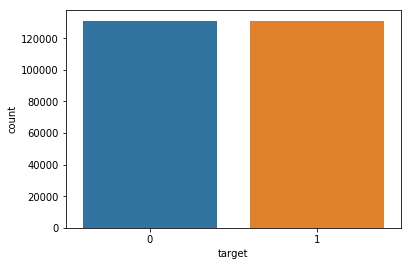

In [32]:
sns.countplot(train_raw.target)
plt.show()

In [33]:
train_raw.target.value_counts()

1    131131
0    131013
Name: target, dtype: int64

Looks like class labels are uniformly distributed in training data.

### Train-validation split

Let's split our training set such that 15% of data are used for validation -

In [34]:
trn_x, valid_x, trn_y, valid_y = train_test_split(train_raw.drop(['id', 'target'], axis=1), train_raw.target, random_state=33, test_size=0.15)
trn_x.shape, valid_x.shape, trn_y.shape, valid_y.shape

((222822, 256), (39322, 256), (222822,), (39322,))

### Categorical Feature

In [35]:
trn_wheezy = pd.get_dummies(trn_x['wheezy-copper-turtle-magic'])
valid_wheezy = pd.get_dummies(valid_x['wheezy-copper-turtle-magic'])
test_wheezy = pd.get_dummies(test_raw['wheezy-copper-turtle-magic'])

trn_wheezy.shape, valid_wheezy.shape, test_wheezy.shape

((222822, 512), (39322, 512), (131073, 512))

In [36]:
trn_x.drop('wheezy-copper-turtle-magic', axis=1, inplace=True)
valid_x.drop('wheezy-copper-turtle-magic', axis=1, inplace=True)
test_raw.drop('wheezy-copper-turtle-magic', axis=1, inplace=True)

### Normalize features

In [37]:
sc = StandardScaler()
trn_x = sc.fit_transform(trn_x)

valid_x = sc.transform(valid_x)
test_x = sc.transform(test_raw.drop('id', axis=1))

In [38]:
trn_x = np.concatenate([trn_x, trn_wheezy.values], axis=1)
valid_x = np.concatenate([valid_x, valid_wheezy.values], axis=1)
test_x = np.concatenate([test_x, test_wheezy.values], axis=1)

### Model

In [39]:
def build_model():
    inp = Input(shape=(trn_x.shape[1],), name='input')
    x = layers.Dense(1000, activation='relu')(inp)
    x = layers.Dropout(0.65)(x)
    x = layers.Dense(750, activation='relu')(x)
    x = layers.Dropout(0.65)(x)
    x = layers.Dense(500, activation='relu')(x)
    x = layers.Dropout(0.6)(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    
    model = Model(inp, x)
    model.compile(optimizer='adam',
                 loss='binary_crossentropy', metrics=['acc'])
    
    return model

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 767)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1000)              768000    
_________________________________________________________________
dropout_4 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 750)               750750    
_________________________________________________________________
dropout_5 (Dropout)          (None, 750)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 500)               375500    
_________________________________________________________________
dropout_6 (Dropout)          (None, 500)               0         
__________

### Training

In [40]:
weights_path = f'weights.best.hdf5'
val_loss_checkpoint = ModelCheckpoint(weights_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
reduceLR = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, mode='min', min_lr=1e-6)

In [41]:
model.fit(trn_x, trn_y, epochs=80, validation_data=(valid_x, valid_y),
         callbacks=[val_loss_checkpoint, reduceLR], batch_size=512, verbose=1)

Train on 222822 samples, validate on 39322 samples
Epoch 1/80
222822/222822 [==============================] - 3s 15us/step - loss: 0.7038 - acc: 0.5015 - val_loss: 0.6931 - val_acc: 0.5076

Epoch 00001: val_loss improved from inf to 0.69312, saving model to weights.best.hdf5
Epoch 2/80
222822/222822 [==============================] - 3s 13us/step - loss: 0.6939 - acc: 0.5034 - val_loss: 0.6931 - val_acc: 0.5129

Epoch 00002: val_loss improved from 0.69312 to 0.69308, saving model to weights.best.hdf5
Epoch 3/80
222822/222822 [==============================] - 3s 12us/step - loss: 0.6933 - acc: 0.5074 - val_loss: 0.6929 - val_acc: 0.5144

Epoch 00003: val_loss improved from 0.69308 to 0.69285, saving model to weights.best.hdf5
Epoch 4/80
222822/222822 [==============================] - 3s 13us/step - loss: 0.6924 - acc: 0.5172 - val_loss: 0.6924 - val_acc: 0.5266

Epoch 00004: val_loss improved from 0.69285 to 0.69240, saving model to weights.best.hdf5
Epoch 5/80
222822/222822 [=======

222822/222822 [==============================] - 3s 13us/step - loss: 0.4901 - acc: 0.7657 - val_loss: 0.5903 - val_acc: 0.6936

Epoch 00037: val_loss improved from 0.59206 to 0.59032, saving model to weights.best.hdf5
Epoch 38/80
222822/222822 [==============================] - 3s 14us/step - loss: 0.4838 - acc: 0.7709 - val_loss: 0.5845 - val_acc: 0.6954

Epoch 00038: val_loss improved from 0.59032 to 0.58446, saving model to weights.best.hdf5
Epoch 39/80
222822/222822 [==============================] - 3s 13us/step - loss: 0.4769 - acc: 0.7744 - val_loss: 0.5852 - val_acc: 0.6965

Epoch 00039: val_loss did not improve from 0.58446
Epoch 40/80
222822/222822 [==============================] - 3s 13us/step - loss: 0.4742 - acc: 0.7768 - val_loss: 0.5866 - val_acc: 0.6989

Epoch 00040: val_loss did not improve from 0.58446
Epoch 41/80
222822/222822 [==============================] - 3s 12us/step - loss: 0.4686 - acc: 0.7797 - val_loss: 0.5852 - val_acc: 0.6993

Epoch 00041: val_loss did

222822/222822 [==============================] - 3s 12us/step - loss: 0.3553 - acc: 0.8453 - val_loss: 0.5557 - val_acc: 0.7208

Epoch 00075: val_loss did not improve from 0.54977

Epoch 00075: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 76/80
222822/222822 [==============================] - 3s 12us/step - loss: 0.3289 - acc: 0.8585 - val_loss: 0.5554 - val_acc: 0.7220

Epoch 00076: val_loss did not improve from 0.54977
Epoch 77/80
222822/222822 [==============================] - 3s 12us/step - loss: 0.3226 - acc: 0.8618 - val_loss: 0.5559 - val_acc: 0.7234

Epoch 00077: val_loss did not improve from 0.54977
Epoch 78/80
222822/222822 [==============================] - 3s 13us/step - loss: 0.3164 - acc: 0.8647 - val_loss: 0.5542 - val_acc: 0.7235

Epoch 00078: val_loss did not improve from 0.54977
Epoch 79/80
222822/222822 [==============================] - 3s 12us/step - loss: 0.3127 - acc: 0.8667 - val_loss: 0.5544 - val_acc: 0.7244

Epoch 00079: val_loss

In [43]:
model.load_weights(weights_path)

### roc_auc_score on validation data

In [44]:
val_preds = model.predict(valid_x, batch_size=2048, verbose=1)

39322/39322 [==============================] - 0s 7us/step


In [45]:
roc_auc_score(valid_y.values, val_preds.reshape(-1))

0.7952916141713527

### Prediction on test data

In [46]:
test_preds = model.predict(test_x, batch_size=2048, verbose=1)

131073/131073 [==============================] - 1s 4us/step


In [47]:
sub_df = pd.read_csv(f'{data_dir}sample_submission.csv')
sub_df.target = test_preds.reshape(-1)
sub_df.head()

,id,target
0,1c13f2701648e0b0d46d8a2a5a131a53,0.674349
1,ba88c155ba898fc8b5099893036ef205,0.801480
2,7cbab5cea99169139e7e6d8ff74ebb77,0.743347
3,ca820ad57809f62eb7b4d13f5d4371a0,0.267272
4,7baaf361537fbd8a1aaa2c97a6d4ccc7,0.200581


In [48]:
sub_df.to_csv('solution.csv', index=False)